# Compare MCC to BM, BA and MK

In this notebook, we sample millions of confusion matrices and visualize how Matthews correlation coefficient (MCC), bookmaker's informedness (BM), balanced accuracy (BA) and markedness (MK) differ for the same underlying confusion matrix.

# Packages

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', **{'size': 9})
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
from scipy import interpolate

from pareto import pareto_frontier_multi

# Sample confusion matrices by varying TPR, TNR and prevalence

As demonstrated in our manuscript, true positve rate (TPR), true negative rate (TNR) and prevalence describe the confusion matrix sufficiently. 
We systematically scan these three parameters to unique confusion matrices.

In [2]:
stepsize = 0.005
vals = np.arange(0, 1. + stepsize, stepsize)
N = len(vals) - 1

In [3]:
TP = []
TN = []
FN = []
FP = []

for prev in vals:
    for TPR in vals:
        for TNR in vals:
            TP.append(prev*TPR)
            TN.append((1-prev) * TNR)
            FN.append(prev*(1-TPR))
            FP.append((1-prev)*(1-TNR))
            
TP = np.array(TP)
TN = np.array(TN)
FN = np.array(FN)
FP = np.array(FP)

# Calculate metrics for sampled confusion matrices

In [4]:
MCC_numerator = TP * TN - FP * FN
MCC_denominator = np.sqrt((TP +FP) * (TP + FN) * (TN + FP) * (TN +FN))

MCC = MCC_numerator / MCC_denominator

<ipython-input-4-137ac4d32d2e>:4: RuntimeWarning: invalid value encountered in true_divide
  MCC = MCC_numerator / MCC_denominator


In [5]:
BM = (TP / (TP + FN)) + (TN / (TN + FP)) - 1

<ipython-input-5-1be47c40b77c>:1: RuntimeWarning: invalid value encountered in true_divide
  BM = (TP / (TP + FN)) + (TN / (TN + FP)) - 1


In [6]:
BA = (BM + 1) / 2 

In [7]:
MK = (TP / (TP + FP)) + (TN / (TN + FN)) - 1

<ipython-input-7-783f07c48bca>:1: RuntimeWarning: invalid value encountered in true_divide
  MK = (TP / (TP + FP)) + (TN / (TN + FN)) - 1


# Plotting

## Pareto plots

Instead of plotting all the samples, we determine the upper left and lower right Pareto fronts of the samples and color everything in between.
This plot is much more efficient than plotting more than 8 million samples, especially if it is stored as a vector graphic.

In [8]:
def interpolate_plot(x=MCC, y=BM):

    df = pd.DataFrame({'x': x, 'y': y})
    curr_df = df.drop_duplicates().dropna()
    upper_left = pareto_frontier_multi(curr_df[['x', 'y']].values, sign_vector=[-1, 1])
    f_upper_left = interpolate.interp1d(upper_left[:,0], upper_left[:,1])

    lower_right = pareto_frontier_multi(curr_df.values, sign_vector=[1, -1])
    f_lower_right = interpolate.interp1d(lower_right[:,0], lower_right[:,1])

    return f_upper_left, f_lower_right

Get pareto fronts for BM and MK. BA is not necessary, we can reuse the one from BM because of their relationship.

In [9]:
BM_ul, BM_lr = interpolate_plot()
MK_ul, MK_lr = interpolate_plot(y=MK)

In [10]:
x_step = 0.005
x_val = np.arange(-1, 1, x_step)

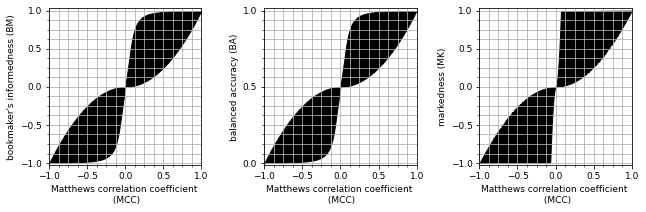

In [11]:
fig, axes = plt.subplots(ncols=3, sharex=True, figsize=(9.1, 3))

for i in range(3):
    axes[i].set_xlabel('Matthews correlation coefficient \n (MCC)')
    axes[i].grid(b=True, which='both')
    axes[i].axis('equal')
    axes[i].set_yticks(np.arange(-1.5, 2, 0.5))
    axes[i].set_xlim(-1, 1)
    axes[i].set_ylim(-1, 1)

    if i == 1:
        axes[i].set_yticks(np.arange(-1, 2, 1))
        axes[i].set_yticklabels(np.arange(0, 1.5, 0.5))

axes[0].fill_between(x_val, BM_ul(x_val), BM_lr(x_val), color='k')
axes[0].set_ylabel("bookmaker's informedness (BM)")
axes[1].fill_between(x_val, BM_ul(x_val), BM_lr(x_val), color='k')
axes[1].set_ylabel("balanced accuracy (BA)")
axes[2].fill_between(x_val, MK_ul(x_val), MK_lr(x_val), color='k')
axes[2].set_ylabel("markedness (MK)")

for i in range(3):
    axes[i].xaxis.set_minor_locator(MultipleLocator(0.125))
    axes[i].yaxis.set_minor_locator(MultipleLocator(0.125))

plt.subplots_adjust(wspace=0.5)

plt.tight_layout()
plt.savefig('MCC_vs_BM_BA_MK.eps')

## Scatter plot

The most natural way would be a scatter plot of all combinations of the metrics. 
Since we have millions of points, vector graphics of scatter plots become very large.
If you want to try, you can find the code below.

In [12]:
# fig, axes = plt.subplots(ncols=3, sharex=True, figsize=(9., 2.75))

# axes[0].scatter(MCC, BM)
# axes[0].set_ylabel("bookmaker's informedness (BM)")
# axes[1].scatter(MCC, BM)
# axes[1].set_ylabel("balanced accuracy (BA)")
# axes[2].scatter(MCC, MK)
# axes[2].set_ylabel("markedness (MK)")

# for i in range(3):
#     axes[i].set_xlabel('Matthews correlation coefficient \n (MCC)')
#     axes[i].grid(b=True)
#     axes[i].axis('equal')
#     axes[i].set_yticks(np.arange(-1.5, 2, 0.5))
    

#     if i == 1:
#         axes[i].set_yticks(np.arange(-1, 2, 1))
#         axes[i].set_yticklabels(np.arange(0, 1.5, 0.5))

# plt.subplots_adjust(wspace=0.5)

# plt.tight_layout()
# plt.savefig('MCC_vs_BM_BA_MK.png', dpi=300)